In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from msresist.figures.figureM4 import predict_mutants
from msresist.clustering import PSPSLdict
import numpy as np
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

## Tweak Upstream Kinases Plot

In [2]:
with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
    model = pickle.load(p)[0]

In [16]:
from sklearn.neighbors import NearestNeighbors

def plotUpstreamKinases(model, ax, clusters, SH2=False, n_components=2, labels=["Component 3", "Component 4"]):
    """Plot Frobenius norm between kinase PSPL and cluster PSSMs"""
    table = model.predict_UpstreamKinases(n_components=n_components)
    pspl = table.iloc[:-model.ncl, :]
    if not SH2:
        pspl = pspl[~pspl["Label"].str.contains("SH2")].set_index("Label")
    if isinstance(clusters, int):
        pssm = pd.DataFrame(table.loc[clusters]).T
    else:
        pssm = table.loc[[clusters]]
    X = pd.concat([pspl, pssm]).set_index("Label")
    if isinstance(ax, np.ndarray):
        p1 = sns.scatterplot(x="Component 1", y="Component 2", hue="Matrix type", data=X, ax=ax[0])
        p2 = sns.scatterplot(x=labels[0], y=labels[1], hue="Matrix Type", data=X, ax=ax[1])
        label_point(X, clusters, p1)
        label_point(X, clusters, p2)
    else:
        p1 = sns.scatterplot(x="Component 1", y="Component 2", hue="Matrix type", data=pspl, ax=ax)
        label_point(X, clusters, p1)

def label_point(X, clusters, ax, n_neighbors=5):
    """Add labels to data points"""
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(X.values)
    if isinstance(clusters, int):
        clusters = [clusters]
    for ii, cluster in enumerate(clusters):
        idc = knn.kneighbors(X.loc[cluster].values.reshape(1, 2), return_distance=False)
        a = X.iloc[idc.reshape(n_neighbors), :].reset_index()
        a.columns = ["val", "x", "y"]
        for _, point in a.iterrows():
            ax.text(point['x']+.02, point['y'], str(point['val']))

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plotUpstreamKinases(model, ax=ax, clusters=11, n_components=2)

ValueError: could not convert string to float: 'PSPL'

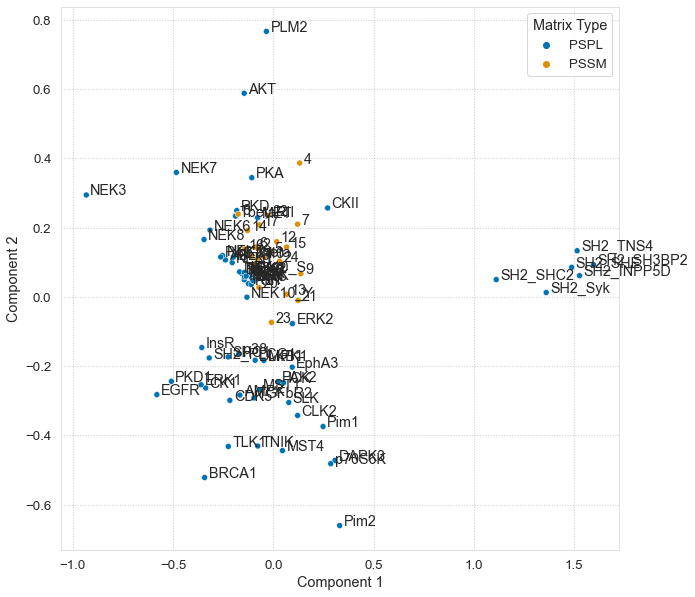

In [5]:
from msresist.figures.figure3 import plotUpstreamKinases

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plotUpstreamKinases(model, ax=ax, n_components=2)

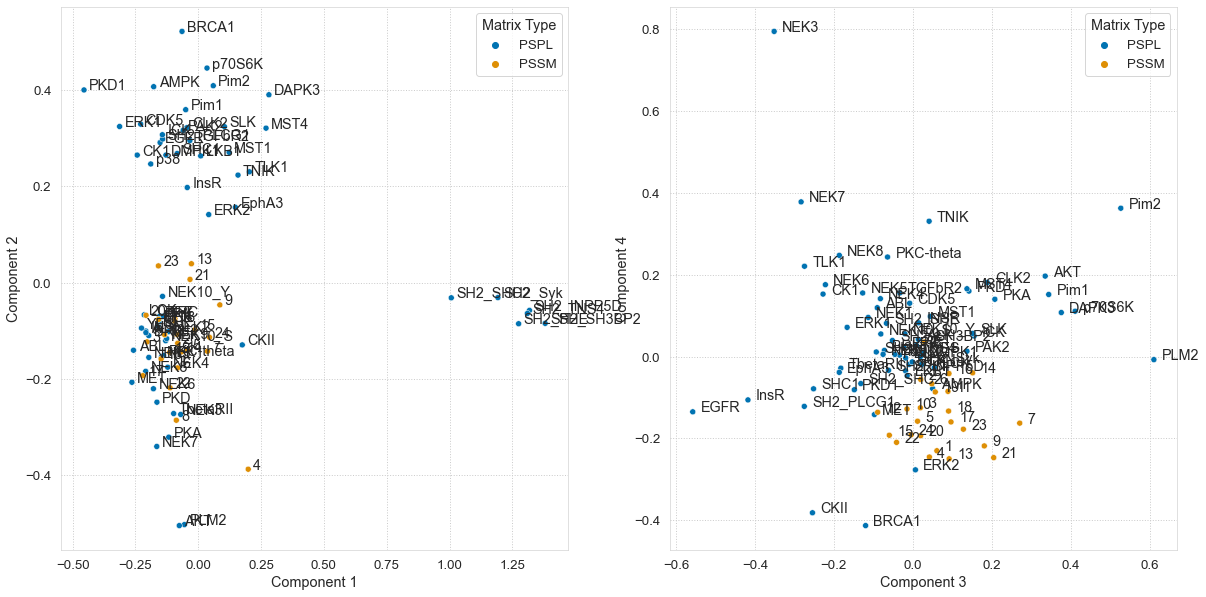

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plotUpstreamKinases(model, ax=ax, n_components=4)

## Regression against methylation

In [8]:
with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
    model = pickle.load(p)[0]

In [158]:
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv").sort_values(by="Sample.ID").set_index("Sample.ID")
mtl = mutations["CIMP.status"]
mtl = mtl[~mtl.index.str.contains("IR")]

In [159]:
centers = pd.DataFrame(model.transform())
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers["Patient_ID"] = X.columns[4:]
centers = centers.set_index("Patient_ID").sort_values(by="Patient_ID")
assert all(mtl.index == centers.index), "sampels not matching"

In [160]:
centers["drop"] = pd.isnull(mtl).values
centers = centers[centers["drop"] == False]

mtl = mtl.dropna().
assert all(centers.index == mtl.index), "samples not matching."